![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# Deep Multivariable Neural Network

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys

import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#pip install --upgrade keras
#pip install --upgrade tensorflow

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity
from keras import metrics

import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')

print(hello)

tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)


We will implement mlflow for training a multivariable deep neural network

### Loading and Cleaning the Data

In [4]:
# Load the training and test sets.

# We will not use this for the models. Uploading this only for comparision reasons. 

X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/y_train.csv')
X_test = pd.read_csv('../Data/X_test.csv')
y_test = pd.read_csv('../Data/y_test.csv')

for dataset in [X_train, y_train, X_test, y_test]:
    print(dataset.shape)

X_train = X_train.drop(X_train.columns[0], axis=1)
y_train = y_train.drop(y_train.columns[0], axis=1)
X_test = X_test.drop(X_test.columns[0], axis=1)
y_test = y_test.drop(y_test.columns[0], axis=1)

for dataset in [X_train, y_train, X_test, y_test]:
    print(dataset.shape)
    
X_train

(1951, 29)
(1951, 2)
(488, 29)
(488, 2)
(1951, 28)
(1951, 1)
(488, 28)
(488, 1)


,comments,duration,languages,num_speaker,film_month,pub_month,film_weekday,pub_weekday,Funny,Beautiful,...,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,pop_ratio,Popular,event_cat_TED,event_cat_TEDx
0,46,956,22,1,4,9,5,3,18,20,...,29,72,238,72,791,754,1.049072,0,0,1
1,25,686,23,1,6,7,5,1,52,319,...,47,5,4,282,1027,11,93.363636,1,1,0
2,40,276,28,1,12,4,2,2,11,123,...,22,31,13,71,312,44,7.090909,1,1,0
3,53,518,24,1,2,2,4,3,202,14,...,79,50,7,24,829,53,15.641509,1,1,0
4,103,878,26,1,2,6,1,3,16,109,...,33,40,1,86,772,30,25.733333,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,104,470,37,1,7,11,2,1,393,245,...,85,48,5,248,1956,33,59.272727,1,1,0
1947,82,703,33,1,6,8,0,1,0,56,...,28,39,2,247,656,17,38.588235,1,0,1
1948,177,239,41,1,2,4,6,4,112,178,...,76,210,209,157,1048,716,1.463687,0,1,0
1949,174,1152,20,1,2,6,4,0,2,256,...,153,51,43,448,1955,238,8.214286,1,1,0


In [5]:
X_train.columns[0]

'comments'

In [6]:
X_test.columns

Index(['comments', 'duration', 'languages', 'num_speaker', 'film_month',
       'pub_month', 'film_weekday', 'pub_weekday', 'Funny', 'Beautiful',
       'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative',
       'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
       'Obnoxious', 'Inspiring', 'positive', 'negative', 'pop_ratio',
       'Popular', 'event_cat_TED', 'event_cat_TEDx'],
      dtype='object')

In [7]:
y_test

,views
0,4376218
1,727807
2,602203
3,1407692
4,620073
...,...
483,736224
484,1101811
485,1419314
486,679711


As mentioned these datasets were only upload so we can compare them later with the actual final dataset we will create below. 

We need to create dummy variables for the variables that should be categorical variables such as film_month, pub_month, etc. and the other categorical variables in the original dataset, such as speaker_occupation, should also be included in the data before analysis is done. 

# Creating the actual cleaned dataset
## Reading in the 'ted' talk data.

In [8]:

ted = pd.read_csv('../Data/ted_main.csv')

In [9]:
# Categorize events into TED and TEDx; exclude those that are non-TED events
ted = ted[ted['event'].str[0:3]=='TED'].reset_index()

In [10]:
ted.loc[:,'event_cat'] = ted['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')
print ("No. of talks remain: ", len(ted))

No. of talks remain:  2439


Here, we change the Unix timstamp to human readable date format. Then we extract month and day of week from film date and published date.

In [11]:

ted['film_date'] = ted['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['published_date'] = ted['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['film_month'] = ted['film_date'].apply(lambda x: x.month)
ted['pub_month'] = ted['published_date'].apply(lambda x: x.month)
ted['film_weekday'] = ted['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
ted['pub_weekday'] = ted['published_date'].apply(lambda x: x.weekday())
ted[['film_date','published_date']].head()

,film_date,published_date
0,2006-02-24,2006-06-26
1,2006-02-24,2006-06-26
2,2006-02-23,2006-06-26
3,2006-02-25,2006-06-26
4,2006-02-21,2006-06-27


TED users can give ratings to each talk. There are 14 possible ratings and they will be categorized as positive, negative and neutral:

Positive: 'Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive' Negative: 'Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing' Neutral: 'OK'

Here, we define a "popular" TED talk by its ratio of positive to negative ratings (which we call it "popularity ratio" here). If the popularity ratio is above 5, it is defined as "Popular", otherwise it is "Not Popular". Transformation is made to avoid "divided by zero" error. The following code is adopted from this kernel to convert 'ratings' column (a JSON object) into columns of each rating

In [15]:

ted['ratings']=ted['ratings'].str.replace("'",'"')
ted=ted.merge(ted.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

In [16]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']
ted['positive']=ted.loc[:,Positive].sum(axis=1)+1
ted['negative']=ted.loc[:,Negative].sum(axis=1)+1
ted['pop_ratio']=ted['positive']/ted['negative']
ted.loc[:,'Popular'] = ted['pop_ratio'].apply (lambda x: 1 if x >5 else 0)

print ("No. of Not Popular talks: ", len(ted[ted['Popular']==0]))
# print ("Ratio of Popular talks: {:.4f}".format(len(ted[ted['Popular']==1])/ float(len(ted))))
overall_mean_popular = np.mean(ted.Popular)
print ("Ratio of Popular talks: {:.4f}".format(overall_mean_popular))

No. of Not Popular talks:  301
Ratio of Popular talks: 0.8766


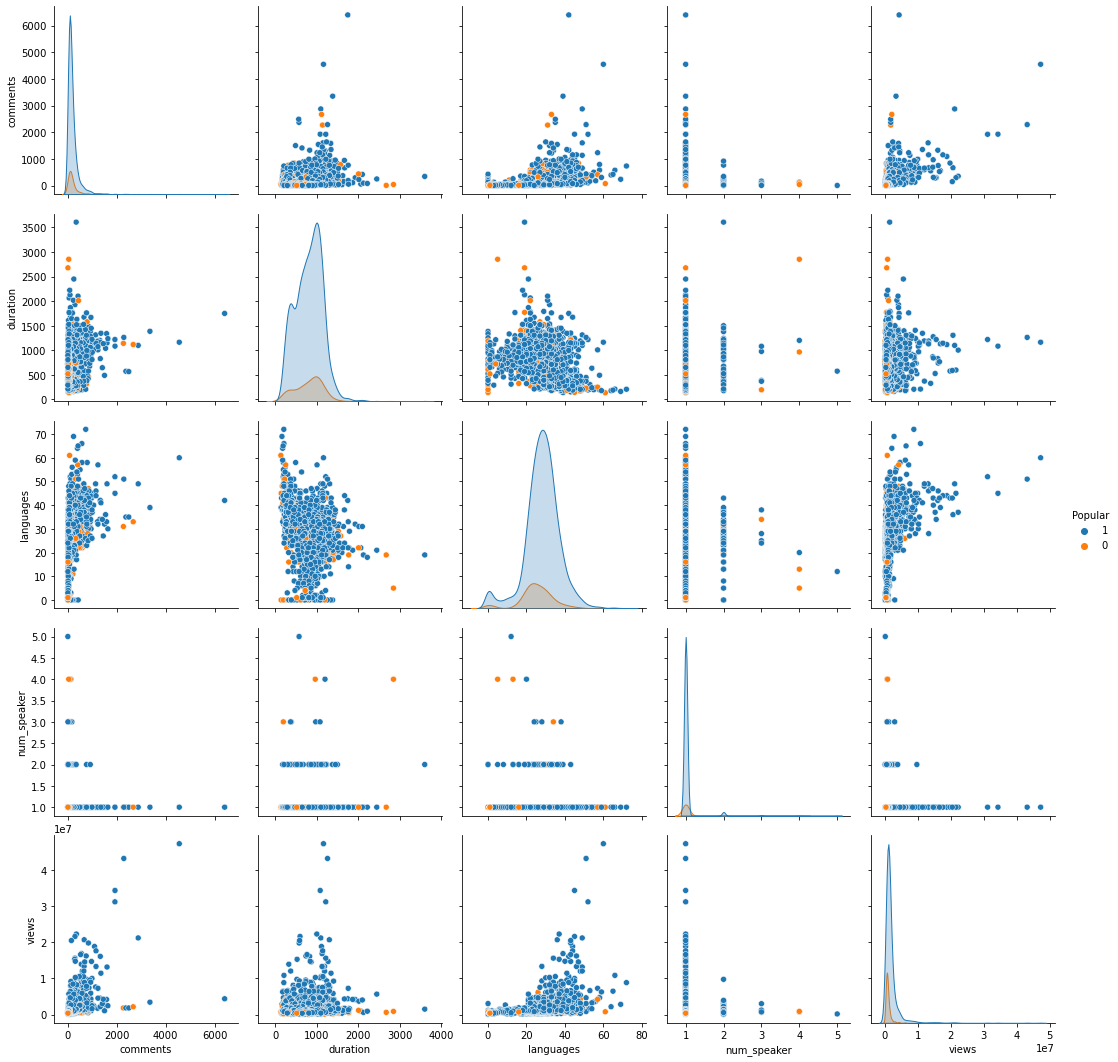

In [17]:
nums = ['comments', 'duration', 'languages', 'num_speaker', 'views']
sns.pairplot(ted, vars=nums, hue='Popular', hue_order = [1,0], diag_kind='kde', height=3);

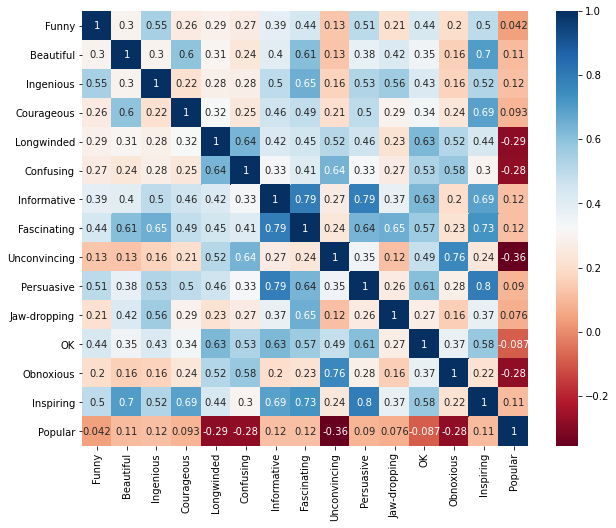

In [18]:
ratings = ['Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing', 
           'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'Popular']
plt.figure(figsize=(10,8))
sns.heatmap(ted[ratings].corr(), annot=True, cmap='RdBu');

Then we do count vectorizer on 'speaker_occupation'. Before that, some data cleaning is needed.

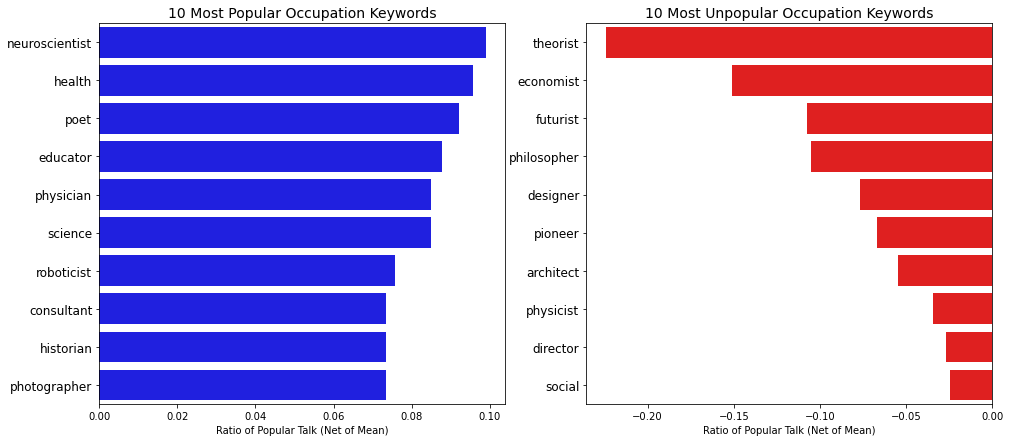

In [19]:

ted.loc[:,'occ'] = ted.speaker_occupation.copy()
ted.occ = ted.occ.fillna('Unknown')
ted.occ = ted.occ.str.replace('singer/songwriter', 'singer, songwriter')
ted.occ = ted.occ.str.replace('singer-songwriter', 'singer, songwriter')
count_vector2 = CountVectorizer(stop_words='english', min_df=20/len(ted))
occ_array = count_vector2.fit_transform(ted.occ).toarray()
occ_matrix = pd.DataFrame(occ_array, columns = count_vector2.get_feature_names())
all_occ = occ_matrix.columns
occ_matrix = pd.concat([occ_matrix, ted.Popular], axis=1)
by_occ = dict()
for col in all_occ:
    by_occ[col]=occ_matrix.groupby(col)['Popular'].mean()[1] - overall_mean_popular
occ_rank = pd.DataFrame.from_dict(by_occ, orient='index')
occ_rank.columns = ['pop_rate_diff']

plt.figure(figsize=(16,7))
plt.subplot(121)
bar_2 = occ_rank.sort_values(by='pop_rate_diff', ascending=False)[:10]
sns.barplot(x=bar_2.pop_rate_diff, y=bar_2.index, color='blue')
plt.title('10 Most Popular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.subplot(122)
bar_1 = occ_rank.sort_values(by='pop_rate_diff')[:10]
sns.barplot(x=bar_1.pop_rate_diff, y=bar_1.index, color='red')
plt.title('10 Most Unpopular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.show()

## Read in the Ted Talk Data again, but this time do not delete the non-TedTalks. Call this data set 'df'.

In [20]:
df = pd.read_csv("../Data/ted_main.csv")
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

In [21]:

df = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]


In [22]:

import datetime
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))

In [23]:

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [24]:
df[['event']]

,event
0,TED2006
1,TED2006
2,TED2006
3,TED2006
4,TED2006
...,...
2545,TED2017
2546,TED2017
2547,TED2017
2548,TEDxMileHigh


In [25]:
df['month'] = df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1])

month_df = pd.DataFrame(df['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']

# Structure of the data

In [26]:
from scipy.stats import pearsonr

In [27]:
corr, _ = pearsonr(df['comments'], df['views']); corr # As can be seen, not much of a correlation between the two.

0.5309387006213678

In [28]:
# if we include all the talks will the correlation between comments and views increase or decrease?

corr, _ = pearsonr(ted['comments'], ted['views']); corr # it decreases!

0.5289031736657247

In [29]:
print("Number of non-Ted talks that we removed were:", len(df) - len(ted))

Number of non-Ted talks that we removed were: 111


## One-Hot encode all the categorical variables. 

## Separate the data into Train and Test sets.

In [30]:
from sklearn.model_selection import train_test_split

In [33]:
ted.columns

Index(['index', 'comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'event_cat', 'film_month', 'pub_month', 'film_weekday',
       'pub_weekday', 'Funny_x', 'Beautiful_x', 'Ingenious_x', 'Courageous_x',
       'Longwinded_x', 'Confusing_x', 'Informative_x', 'Fascinating_x',
       'Unconvincing_x', 'Persuasive_x', 'Jaw-dropping_x', 'OK_x',
       'Obnoxious_x', 'Inspiring_x', 'Funny_y', 'Beautiful_y', 'Ingenious_y',
       'Courageous_y', 'Longwinded_y', 'Confusing_y', 'Informative_y',
       'Fascinating_y', 'Unconvincing_y', 'Persuasive_y', 'Jaw-dropping_y',
       'OK_y', 'Obnoxious_y', 'Inspiring_y', 'Funny', 'Beautiful', 'Ingenious',
       'Courageous', 'Longwinded', 'Confusing', 'Informative', 'Fascinating',
       'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious',
       'Inspiring', 

In [34]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(ted.drop('views',axis = 1), ted.views, test_size=0.2, random_state=1)

In [35]:
for set in [X_train, X_test, y_train, y_test]:
    print( len(set))

1951
488
1951
488


## After seperating the data need to normalize the continuous variables separately for train and test sets. 

Hopefully this will improve the performance.

## We shall now do Feature Selection and Data Compression. 

# Building a Deep Neural Network

We will build a deep neural network. The first one we will build will be of 6 hidden layers. For the 6 layer neural network we will do a hyperparameter search. The optimzed hyperparameter we will then use for all the subsequent deep neural networks. We will try deep neural networks with 12, 24, and 50 hidden layers.

Hidden Layers:
1. 6
2. 12
3. 24
4. 50

Use for loops to vary the number of hidden layers. 



In [36]:
def model_results(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,

                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=0,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]

    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim=input_dimensions, activation=activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))

    # Hidden Layers

    for i in range(num_hiddenlayer):
        
        model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    #model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    #model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))
    
    #model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    #model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    #model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()
                      , CosineSimilarity(), RootMeanSquaredError(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split)
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'mse_test': [score[1]],
            'mae_test': [score[2]],
            'mape_test': [score[3]],
            'cosine_similarity_test': [score[4]],
            'rmse_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)


model_0 = model_results(0)
model_0

NameError: name 'MeanSquaredError' is not defined